In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import Bounds
from matplotlib import pyplot as plt
import seaborn as sns
import pandas_datareader as pdr
import pandas_market_calendars as mcal
import datetime
import math

In [4]:
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=365) #52 week analysis
nyse = mcal.get_calendar('NYSE')
valid_dates = nyse.valid_days(start_date=start_date, end_date =end_date)
valid_start_day = valid_dates[0].date()
valid_end_day = valid_dates[-1].date()

top_150_us_stocks = [
    "AAPL", "NVDA", "MSFT", "GOOGL", "AMZN", "META", "BRK-A", "LLY", "TSM", "AVGO",
    "TSLA", "JPM", "WMT", "SONY", "UNH", "V", "XOM", "NVO", "MA", "PG", "JNJ", "COST",
    "ORCL", "HD", "ASML", "ABBV", "BAC", "KO", "MRK", "NFLX", "AZN", "CVX", "SMFG",
    "SAP", "CRM", "ADBE", "TM", "NVS", "PEP", "AMD", "TMUS", "TMO", "LIN", "ACN",
    "MCD", "CSCO", "ABT", "WFC", "BABA", "INTC", "IBM", "QCOM", "NVS", "UPS", "HON",
    "AMGN", "SBUX", "PFE", "INTU", "FDX", "MDT", "CHTR", "TGT", "LMT", "AMT", "WBA",
    "TFC", "TXN", "BLK", "CVS", "NOW", "SBAC", "MU", "ISRG", "GM", "DHR", "TJX",
    "ADI", "PYPL", "ZTS", "DUK", "CAT", "LOW", "PLD", "MS", "EL", "FIS", "ADP",
    "SO", "BDX", "MDLZ", "FDX", "GS", "SCHW", "KEP", "NEE", "CL", "BKNG", "CSX",
    "ADI", "ICE", "MCO", "EA", "GD", "TFC", "TD", "AON", "WDAY", "APD", "EQIX",
    "KMB", "CCI", "ETN", "SYK", "SPGI", "HUM", "EMR", "INTC", "NSC", "EXC", "WM",
    "BMY", "FISV", "LRCX", "VZ", "ROST", "EW", "PGR", "STZ", "AEP", "KLAC", "BSX",
    "APTV", "MU", "AIG", "ORLY", "NSC", "AFL"
]
index_banch_mart = ["^GSPC"]

tickers = top_150_us_stocks
df = yf.download(tickers,start = valid_start_day)["Adj Close"]
df_SnP = yf.download(index_banch_mart,start = valid_start_day)["Adj Close"]
number_of_stocks = df.shape[1]

[*********************100%%**********************]  131 of 131 completed
[*********************100%%**********************]  1 of 1 completed


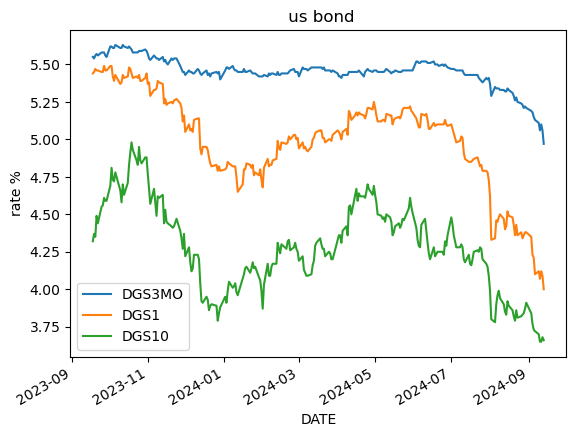

In [4]:
US_TB = ['DGS3MO', 'DGS1', 'DGS10'] #3 months, 1 year, 10 years

df_bonds = pdr.DataReader(US_TB, 'fred', valid_start_day, valid_end_day).dropna()
df_bonds["3month_cts_rate"] = (1+df_bonds["DGS3MO"]/100)**(1/360) -1 
risk_free_rate = df_bonds["3month_cts_rate"]

df_bonds["DGS3MO"].plot(title = " us bond", ylabel="rate %")
#df_bonds["3month_cts_rate"].plot()
df_bonds["DGS1"].plot( )
df_bonds["DGS10"].plot( )
plt.legend()
plt.show()

In [5]:
ret_df = np.log(df/df.shift(1)).dropna()
ret_df_SnP = np.log(df_SnP/df_SnP.shift(1)).dropna()

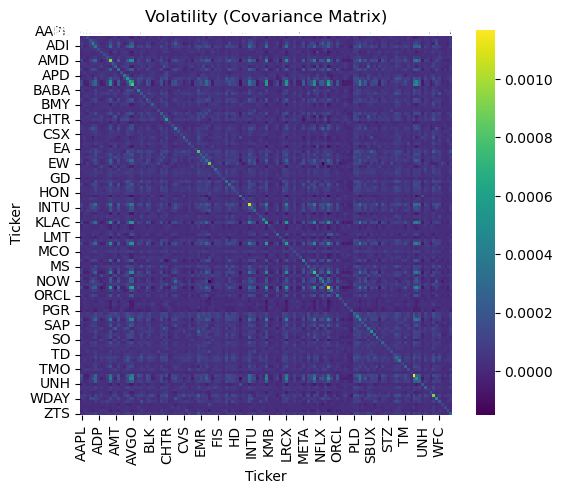

In [6]:
Covarian_matrix = ret_df.cov()
plt.figure(figsize=(6, 5))
sns.heatmap(Covarian_matrix, annot=True, cmap='viridis', fmt='.2e')
plt.title('Volatility (Covariance Matrix)')
plt.show()

Optimization Time

In [8]:
def Sharpe_pf(Weight,return_df,risk_free_rate):
    pf_risk = np.sqrt(Weight.dot(return_df.cov().dot(Weight)))
    pf_mean = return_df.mean().dot(Weight)
    if type(risk_free_rate) != int:
        risk_free_rate = risk_free_rate.mean()
    return -(pf_mean-risk_free_rate)/pf_risk
def Expected_return(Weight,return_df):
    return return_df.dot(Weight).cumsum().dropna()

In [9]:
T_fraction = 0.9
common_indices = ret_df.index.intersection(risk_free_rate.index)

ret_df_matched = ret_df.loc[common_indices]
risk_free_rate_matched = risk_free_rate.loc[common_indices]

common_indices = ret_df_SnP.index.intersection(risk_free_rate_matched.index)
ret_df_SnP_matched = ret_df_SnP.loc[common_indices]

Train = ret_df_matched[:int(len(ret_df_matched)*T_fraction)]
Test = ret_df_matched[int(len(ret_df_matched)*T_fraction):]

Train_rfr_cts = risk_free_rate_matched[:int(len(risk_free_rate_matched)*T_fraction)]
Test_rfr_cts = risk_free_rate_matched[int(len(risk_free_rate_matched)*T_fraction):]

Train_rfr = Train_rfr_cts
Test_rfr = Test_rfr_cts

In [10]:
cons = ({"type":"eq", "fun":lambda x:np.sum(x) - 1})

In [11]:
W_0 = np.ones(number_of_stocks)/number_of_stocks
Train_result = minimize(Sharpe_pf,W_0,args=(Train,Train_rfr), bounds=Bounds(0,1),constraints = cons)
W_opt_train = Train_result["x"]

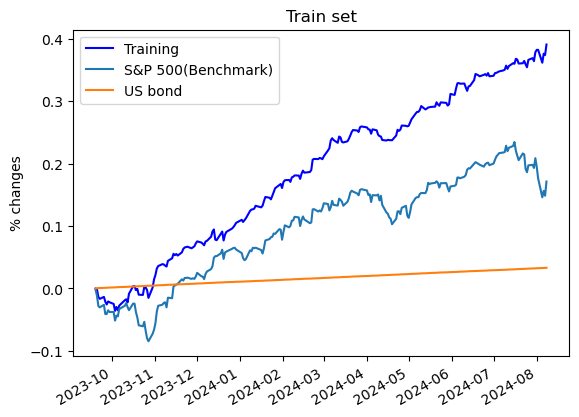

In [12]:
ER_train  = Expected_return(W_opt_train,Train)
ER_train.plot(c="b",title="Train set",ylabel="% changes",label="Training")
ret_df_SnP_matched[:int(len(ret_df_SnP_matched)*T_fraction)].cumsum().plot(label="S&P 500(Benchmark)")
Train_rfr_cts.cumsum().plot(label="US bond")
plt.legend()
plt.show()

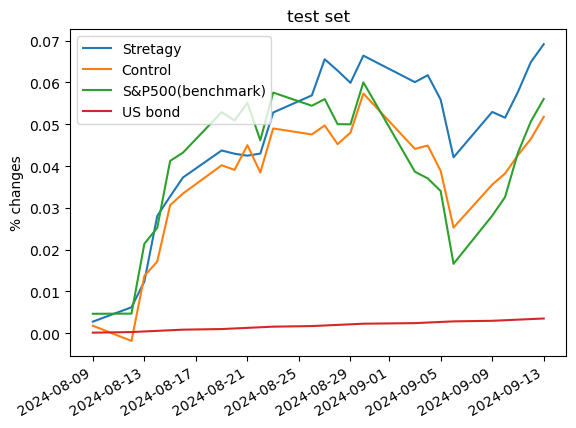

In [13]:
ER_Test  = Expected_return(W_opt_train,Test)
ER_final = ER_Test.to_list()[-1]
sharpe_ratio = -Sharpe_pf(W_opt_train,Test,Test_rfr)

ER_control = Expected_return(W_0,Test)
ER_control_final = ER_control.to_list()[-1]
Control_shape_ratio = -Sharpe_pf(W_0,Test,Test_rfr)

SnP_cumsum = ret_df_SnP_matched[int(len(ret_df_SnP_matched)*T_fraction):].cumsum()
SnP_cumsum_final = SnP_cumsum.tolist()[-1]

ER_Test.plot(title="test set",ylabel="% changes",label="Stretagy")
ER_control.plot(label="Control")
SnP_cumsum.plot(label="S&P500(benchmark)")
Test_rfr_cts.cumsum().plot(label="US bond")
plt.legend()
plt.show()

In [14]:
print(f"The return for the test data is {ER_final*100:.2f}% with sharpe ratio {sharpe_ratio:.3f}")
print(f"Control return is {ER_control_final*100:.2f}% with sharpe ratio {Control_shape_ratio:.3f}")
print(f"S&P500 return is {SnP_cumsum_final*100:.2f}%")

The return for the test data is 6.92% with sharpe ratio 0.420
Control return is 5.18% with sharpe ratio 0.264
S&P500 return is 5.61%


In [15]:
def What_Should_I_buy(Ticker,Weight):
    buy_list = {}
    print("you should buy:")
    print("-------------------------")
    lower_limit = 0.1
    Weight_adj = [X if X >= lower_limit else 0 for X in Weight]
    Weight_adj = 1/sum(Weight_adj)*np.array(Weight_adj)
    for T, W in zip(Ticker, Weight_adj):
        if W > lower_limit:
            buy_list[T] = W
            print(f"W_{T} =  {W:.2f}")
    print("-------------------------")
    return buy_list
print("For the test set")
Test_buy_list = What_Should_I_buy(tickers,W_opt_train)


For the test set
you should buy:
-------------------------
W_CVX =  0.33
W_NOW =  0.21
W_NEE =  0.22
W_EMR =  0.25
-------------------------


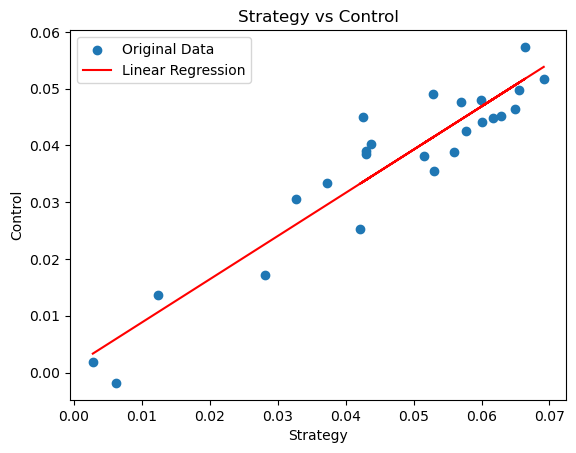

alpha and beta are 0.001, 0.761


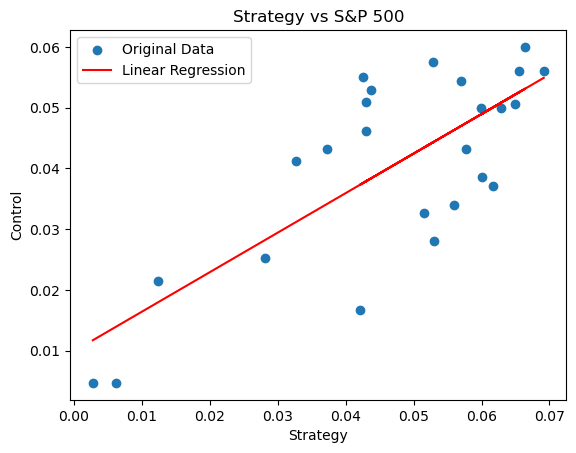

alpha and beta are 0.01, 0.651


In [16]:
import Functions.AlphaBeta as MT
plt.title("Strategy vs Control")
alpha, beta = MT.AlphaBeta(ER_Test.to_list(),ER_control.to_list(),0,plot=True)
print(f"alpha and beta are {alpha}, {beta}")

plt.title("Strategy vs S&P 500")
alpha, beta = MT.AlphaBeta(ER_Test.to_list(),SnP_cumsum.to_list(),0,plot=True)
print(f"alpha and beta are {alpha}, {beta}")


In [17]:
Today_rfr = risk_free_rate
#Today_rfr = 0
Final_result = minimize(Sharpe_pf,W_0,args=(ret_df,Today_rfr), bounds=Bounds(0,1),constraints = cons)
W_opt_final = Final_result["x"]

In [18]:
mylist = What_Should_I_buy(tickers,W_opt_final)
print("Overlapped stock with the test set are:")
for X in mylist:
    if X in Test_buy_list:
        print(f"Delta_W_{X} = {(Test_buy_list[X]-mylist[X]):2f}")
print("------------------------")

you should buy:
-------------------------
W_CVX =  0.21
W_NOW =  0.21
W_NEE =  0.25
W_EMR =  0.17
W_STZ =  0.16
-------------------------
Overlapped stock with the test set are:
Delta_W_CVX = 0.119110
Delta_W_NOW = -0.005802
Delta_W_NEE = -0.029950
Delta_W_EMR = 0.079598
------------------------


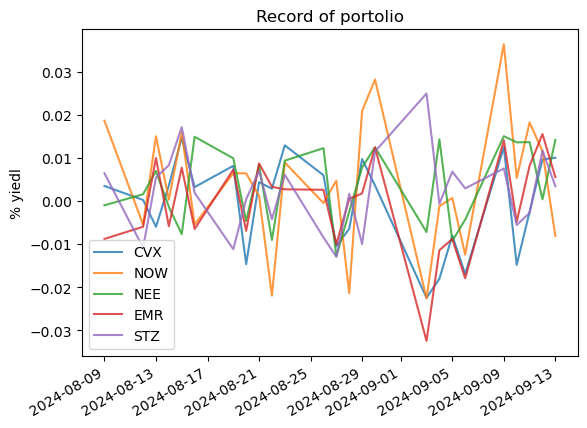

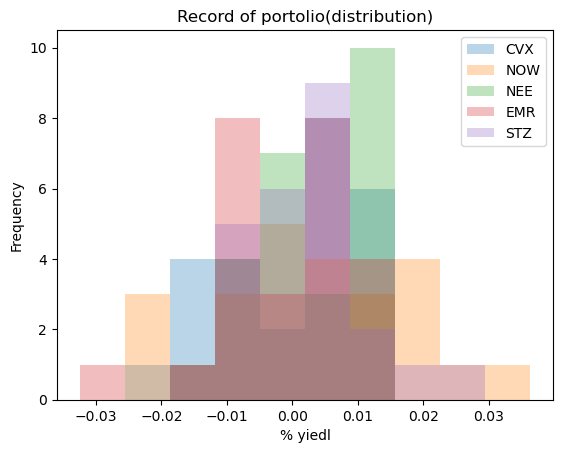

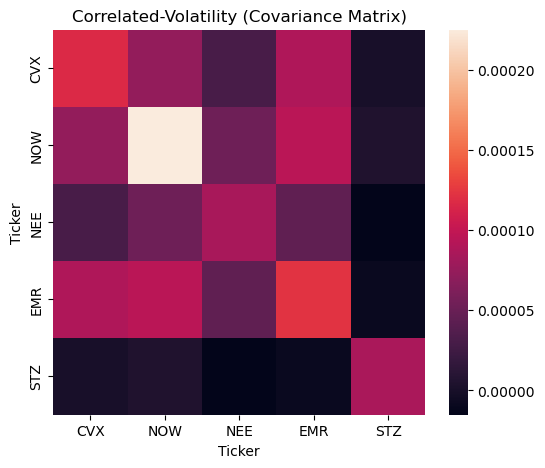

In [19]:
def track_record(your_list):
    ticker = list(mylist.keys())
    #df[ticker].plot(label=ticker,ylabel="Stock price",title="Record of portolio")
    #plt.legend()
    #plt.show()

    Test[ticker].plot(label=ticker,ylabel="% yiedl",title="Record of portolio", alpha =0.8)
    plt.legend()
    plt.show()
    
    Test[ticker].plot.hist(label=ticker,xlabel="% yiedl",title="Record of portolio(distribution)",bins=10, alpha =0.3)
    plt.legend()
    plt.show()

    Covarian_matrix = Test[ticker].cov()
    plt.figure(figsize=(6, 5))
    heatmap = sns.heatmap(Covarian_matrix, annot=False, fmt=".2e", annot_kws={"size": 9},cbar=True)
    plt.title('Correlated-Volatility (Covariance Matrix)')
    plt.show()

track_record(mylist)

In [40]:
def How_much_money_I_need_now(your_list):
    ticker = list(mylist.keys())
    start_date = valid_end_day
    Opens = yf.download(ticker,start = start_date)["Open"]
    n_stock = [1]*len(your_list)
    for i in range(len(ticker)):
        n_stock[i] = int(your_list[ticker[i]]*100)
    n_stock = np.array(n_stock)
    GCD = math.gcd(max(n_stock),min(n_stock))
    for i in range(len(n_stock)):
        GCD = math.gcd(GCD,n_stock[i])
    n_stock = n_stock/GCD
    prices = np.array(Opens.values[0])
    Need_Cash = sum(n_stock*prices)
    print("Full strategy:")
    print("Buy")
    for T, N in zip(ticker, n_stock):
        print(f"{N} stock of {T} at {Opens[T].values[0]:.2f}")
        print(f"portfolio weighting = {N*Opens[T].values[0]/Need_Cash*100} %")
        print("---------------------------------------------")
    print(f"Total cash needed is {Need_Cash:.2f} USD")
    print("=================================================")
    rounded_n_stock = np.array([round(x/10) for x in n_stock])
    Need_Cash_simple = sum(rounded_n_stock*prices)
    
    print("Simple strategy:")
    print("Buy")
    for T, N in zip(ticker, rounded_n_stock):
        print(f"{N} stock of {T} at {Opens[T].values[0]:.2f}")
        print(f"portfolio weighting = {N*Opens[T].values[0]/Need_Cash_simple*100} %")
        print("------------------------------------------------")
    print(f"Total cash(Simple) needed is {Need_Cash_simple:.2f} USD")
    
How_much_money_I_need_now(mylist)


[*********************100%%**********************]  5 of 5 completed

Full strategy:
Buy
21.0 stock of CVX at 141.80
portfolio weighting = 11.695584945218245 %
---------------------------------------------
21.0 stock of NOW at 890.65
portfolio weighting = 73.46031588725161 %
---------------------------------------------
24.0 stock of NEE at 84.79
portfolio weighting = 7.992493547212755 %
---------------------------------------------
16.0 stock of EMR at 102.81
portfolio weighting = 6.4607322656253015 %
---------------------------------------------
16.0 stock of STZ at 252.42
portfolio weighting = 15.86244592341075 %
---------------------------------------------
Total cash needed is 25460.89 USD
Simple strategy:
Buy
2 stock of CVX at 141.80
portfolio weighting = 9.630077402599262 %
------------------------------------------------
2 stock of NOW at 890.65
portfolio weighting = 60.48680175700476 %
------------------------------------------------
2 stock of NEE at 84.79
portfolio weighting = 5.758351581169931 %
-----------------------------------------------